In [4]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size = 5, padding = 2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Conv2d(6, 16, kernel_size = 5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10)
                   )

In [5]:
X = torch.rand(size=(1, 1, 28, 28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:', X.shape)

Conv2d output shape: torch.Size([1, 6, 28, 28])
Sigmoid output shape: torch.Size([1, 6, 28, 28])
AvgPool2d output shape: torch.Size([1, 6, 14, 14])
Conv2d output shape: torch.Size([1, 16, 10, 10])
Sigmoid output shape: torch.Size([1, 16, 10, 10])
AvgPool2d output shape: torch.Size([1, 16, 5, 5])
Flatten output shape: torch.Size([1, 400])
Linear output shape: torch.Size([1, 120])
Sigmoid output shape: torch.Size([1, 120])
Linear output shape: torch.Size([1, 84])
Sigmoid output shape: torch.Size([1, 84])
Linear output shape: torch.Size([1, 10])


In [6]:
# 模型训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)] # 逻辑：通过 zip 配对原有数据和新数据，逐个元素相加
 
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
# 使用GPU计算模型在数据集上的精度
def evaluate_accuracy_gpu(net, data_iter, device = None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
        

net.parameters() 返回模型中所有可学习参数（如权重、偏置）的迭代器
iter(net.parameters()) 将其转换为迭代器对象
next(...) 获取迭代器的第一个元素（即模型的第一个参数张量）
.device 获取该参数张量所在的设备（torch.device 对象）

神经网络中有些层的行为在 “训练” 和 “评估” 时是不同的，net.eval() 会显式关闭这些层的 “训练模式行为”：

Dropout 层
训练时：随机 “丢弃” 一部分神经元（防止过拟合），输出会被缩放以保持期望不变；
评估时（eval() 后）：不丢弃任何神经元，所有神经元正常参与计算，输出也不再缩放。
若不调用 eval()，评估时 Dropout 仍会随机丢弃神经元，导致预测结果不稳定（同一样本多次预测结果不同）。
Batch Normalization 层
训练时：使用当前批次数据的均值和方差更新滑动平均（running mean）和滑动方差（running var）；
评估时（eval() 后）：不再使用当前批次的均值 / 方差，而是固定使用训练阶段积累的滑动平均和滑动方差，确保对单个样本或小批次数据的预测稳定。
若不调用 eval()，评估时会用测试数据的批次统计量，导致结果受测试批次影响（如单样本评估时均值为自身，结果偏差）。

In [12]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec' f'on {str(device)}')

loss 0.460, train acc 0.828, test acc 0.816
95981.6 examples/secon cuda:0


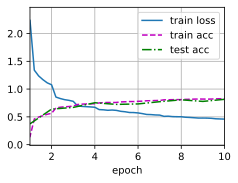

In [13]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

net.apply(init_weights)
net 是定义好的神经网络模型（继承自 nn.Module）。
apply(init_weights) 是 nn.Module 的内置方法，作用是将 init_weights 函数递归地应用到 net 中的所有子模块上。

enumerate 是 Python 内置函数，用于同时获取 “迭代对象的索引” 和 “元素值”。
在这里，它会为 train_iter 中的每个批次数据添加一个索引 i（从 0 开始），方便记录当前是第几个批次。

在 PyTorch 中，nn.CrossEntropyLoss() 已经默认对批次内的损失值做了平均（mean），因此不需要手动调用 .mean()。这是由该损失函数的内部实现决定的，具体原因如下：
1. nn.CrossEntropyLoss 的默认行为
nn.CrossEntropyLoss 是分类任务中常用的损失函数，它的核心逻辑是：

先对每个样本计算交叉熵损失（单个样本的损失）；
然后自动对批次内所有样本的损失进行 “平均” 或 “求和”（默认是平均）。

要理解 “既调用 optimizer.zero_grad() 又用 with torch.no_grad():” 的原因，核心是区分 “梯度计算 / 更新” 和 “指标统计 / 参数访问” 这两个完全独立的操作 —— 两者针对的目标不同，解决的问题也不同，因此需要同时使用。

with torch.no_grad():	代码块内的张量计算	临时关闭 “梯度计算跟踪”（即使对参数进行操作，也不会生成计算图、不会记录梯度）	1. 避免统计指标（如损失、准确率）的计算生成无用计算图，节省内存；
2. 防止误操作（如修改参数）导致梯度污染